In [ ]:
import warnings
warnings.filterwarnings('ignore')
import re
import os
import sys
import json

import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from bs4 import BeautifulSoup
import unicodedata
from textblob import TextBlob
import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 KB 3.0 MB/s eta 0:00:00


In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

query = "(disaster, OR accident) lang:en until:2023-05-31 since:2006-01-01"
tweets = []
limit = 50000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    
    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content, tweet.retweetCount, tweet.user.followersCount, tweet.hashtags, tweet.coordinates, tweet.place, tweet.likeCount])
        
df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet', 'Retweets', 'Followers', 'Hashtags', 'Location', 'Place', 'Likes'])
print(df)

                           Date            User  \
0     2023-02-08 05:06:05+00:00         KenRaty   
1     2023-02-08 05:06:01+00:00  DileepKumarPak   
2     2023-02-08 05:06:00+00:00         DSWDfo7   
3     2023-02-08 05:05:48+00:00         migzu17   
4     2023-02-08 05:05:47+00:00   darrellriffic   
...                         ...             ...   
49995 2023-02-06 22:33:15+00:00  PresumablyRori   
49996 2023-02-06 22:33:13+00:00        HAFID500   
49997 2023-02-06 22:33:12+00:00     Jennaacarey   
49998 2023-02-06 22:33:05+00:00    WendyWeidman   
49999 2023-02-06 22:33:03+00:00     ZinedinIsco   

                                                   Tweet  Retweets  Followers  \
0      @WallyBigWall @JonesHospodTX @cFidd I love it ...         0        106   
1      Search and rescue operations resumed at the si...         0        280   
2      Our community volunteers in Brgy. Canagahan of...         0       1904   
3      @yugivee By accident. I was originally going t...       

In [ ]:
df

,Date,User,Tweet,Retweets,Followers,Hashtags,Location,Place,Likes
0,2023-02-08 05:06:05+00:00,KenRaty,@WallyBigWall @JonesHospodTX @cFidd I love it ...,0,106,None,None,None,0
1,2023-02-08 05:06:01+00:00,DileepKumarPak,Search and rescue operations resumed at the si...,0,280,"[Gilgit, Rawalpindi, Pakistan, accident, CarBu...",None,None,0
2,2023-02-08 05:06:00+00:00,DSWDfo7,Our community volunteers in Brgy. Canagahan of...,0,1904,None,None,None,0
3,2023-02-08 05:05:48+00:00,migzu17,@yugivee By accident. I was originally going t...,0,416,None,None,None,0
4,2023-02-08 05:05:47+00:00,darrellriffic,@hishyar09205113 @Mdoe99500351 @BozturkSerkan ...,0,54,None,None,None,0
...,...,...,...,...,...,...,...,...,...
49995,2023-02-06 22:33:15+00:00,PresumablyRori,"@Me_chame_de_Luz That is true, but they picked...",0,16,None,None,None,15
49996,2023-02-06 22:33:13+00:00,HAFID500,@StateDeptSpox You criminals are the first res...,2,106,None,None,None,44
49997,2023-02-06 22:33:12+00:00,Jennaacarey,Sooo they're favoring the CO in this case beca...,0,522,None,None,None,0
49998,2023-02-06 22:33:05+00:00,WendyWeidman,East Palestine disaster has been brewing for y...,4,4338,None,None,None,12


In [ ]:
nlp = en_core_web_sm.load()

def get_wordcounts(x):
  length = len(str(x).split())
  return length

def get_charcounts(x):
  s = x.split()
  x = ''.join(s)
  return len(x)

def get_avg_wordlength(x):
  count = get_charcounts(x)/get_wordcounts(x)
  return count

def get_stopwords_counts(x):
  l = len([t for t in x.split() if t in stopwords])
  return l

def get_hashtag_counts(x):
  l = len([t for t in x.split() if t.startswith('#')])
  return l

def get_mentions_counts(x):
  l = len([t for t in x.split() if t.startswith('@')])
  return l

def get_digit_counts(x):
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

def get_uppercase_counts(x):
	return len([t for t in x.split() if t.isupper()])

def cont_exp(x):
	if type(x) is str:
		for key in abbreviations:
			value = abbreviations[key]
			raw_text = r'\b' + key + r'\b'
			x = re.sub(raw_text, value, x)
			# print(raw_text,value, x)
		return x
	else:
		return x
  
def get_emails(x):
	emails = re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', x)
	counts = len(emails)

	return counts, emails

def remove_emails(x):
	return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

def get_urls(x):
	urls = re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)
	counts = len(urls)

	return counts, urls

def remove_urls(x):
	return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def remove_rt(x):
	return re.sub(r'\brt\b', '', x).strip()

def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

def remove_html_tags(x):
	return BeautifulSoup(x, 'lxml').get_text().strip()

def remove_accented_chars(x):
	x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
	return x

def remove_stopwords(x):
	return ' '.join([t for t in x.split() if t not in stopwords])	

def make_base(x):
	x = str(x)
	x_list = []
	doc = nlp(x)
	
	for token in doc:
		lemma = token.lemma_
		if lemma == '-PRON-' or lemma == 'be':
			lemma = token.text

		x_list.append(lemma)
	return ' '.join(x_list)

def get_value_counts(df, col):
	text = ' '.join(df[col])
	text = text.split()
	freq = pd.Series(text).value_counts()
	return freq

def remove_common_words(x, freq, n=20):
	fn = freq[:n]
	x = ' '.join([t for t in x.split() if t not in fn])
	return x

def remove_rarewords(x, freq, n=20):
	fn = freq.tail(n)
	x = ' '.join([t for t in x.split() if t not in fn])
	return x

def remove_dups_char(x):
	x = re.sub("(.)\\1{2,}", "\\1", x)
	return x

def spelling_correction(x):
	x = TextBlob(x).correct()
	return x

def get_basic_features(df):
	if type(df) == pd.core.frame.DataFrame:
		df['char_counts'] = df['Tweet'].apply(lambda x: get_charcounts(x))
		df['word_counts'] = df['Tweet'].apply(lambda x: get_wordcounts(x))
		df['avg_wordlength'] = df['Tweet'].apply(lambda x: get_avg_wordlength(x))
		df['stopwords_counts'] = df['Tweet'].apply(lambda x: get_stopwords_counts(x))
		df['hashtag_counts'] = df['Tweet'].apply(lambda x: get_hashtag_counts(x))
		df['mentions_counts'] = df['Tweet'].apply(lambda x: get_mentions_counts(x))
		df['digits_counts'] = df['Tweet'].apply(lambda x: get_digit_counts(x))
		df['uppercase_counts'] = df['Tweet'].apply(lambda x: get_uppercase_counts(x))
	else:
		print('ERROR: This function takes only Pandas DataFrame')
		
	return df

def get_ngram(df, col, ngram_range):
	vectorizer = CountVectorizer(ngram_range=(ngram_range, ngram_range))
	vectorizer.fit_transform(df[col])
	ngram = vectorizer.vocabulary_
	ngram = sorted(ngram.items(), key = lambda x: x[1], reverse=True)

	return ngram

In [ ]:
df = get_basic_features(df)

In [ ]:
df.head()

,Date,User,Tweet,Retweets,Followers,Hashtags,Location,Place,Likes,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,2023-02-08 05:06:05+00:00,KenRaty,@WallyBigWall @JonesHospodTX @cFidd I love it ...,0,106,None,None,None,0,168,33,5.090909,16,0,5,3,1
1,2023-02-08 05:06:01+00:00,DileepKumarPak,Search and rescue operations resumed at the si...,0,280,"[Gilgit, Rawalpindi, Pakistan, accident, CarBu...",None,None,0,138,18,7.666667,4,5,0,3,0
2,2023-02-08 05:06:00+00:00,DSWDfo7,Our community volunteers in Brgy. Canagahan of...,0,1904,None,None,None,0,188,28,6.714286,6,0,1,7,1
3,2023-02-08 05:05:48+00:00,migzu17,@yugivee By accident. I was originally going t...,0,416,None,None,None,0,160,38,4.210526,17,0,1,5,4
4,2023-02-08 05:05:47+00:00,darrellriffic,@hishyar09205113 @Mdoe99500351 @BozturkSerkan ...,0,54,None,None,None,0,301,57,5.280702,33,0,4,8,0


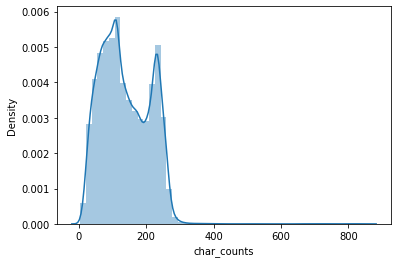

In [ ]:
import seaborn as sns
sns.distplot(df['char_counts'])

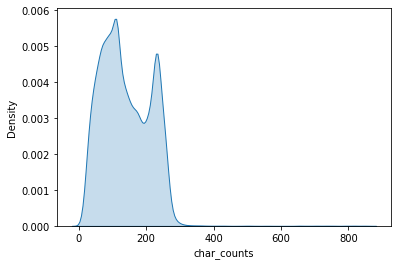

In [ ]:
sns.kdeplot(df['char_counts'], shade=True)

In [ ]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
bigram = get_ngram(df, 'Tweet', ngram_range=2)

In [ ]:
def get_clean(x):
  x = str(x).lower().replace('\\', '').replace('_', ' ').replace('.',' ')
  x = cont_exp(x)
  x = remove_emails(x)
  x = remove_urls(x)
  x = remove_html_tags(x)
  x = remove_rt(x)
  x = remove_accented_chars(x)
  x = remove_special_chars(x)
  x = remove_dups_char(x)
  #x = re.sub("(.)\\1{2,}", "\\1", x)
  return x

In [ ]:
df['Tweet'] = df['Tweet'].apply(lambda x: get_clean(x))

In [ ]:
df.head()['Tweet']

0    wallybigwall joneshospodtx cfidd i love it but...
1    search and rescue operations resumed at the si...
2    our community volunteers in brgy canagahan of ...
3    yugivee by accident i was originally going to ...
4    hishyar09205113 mdoe99500351 bozturkserkan dor...
Name: Tweet, dtype: object

In [ ]:
# get_ngram(df, 'Tweet', ngram_range=2)

[('zzyrrl im', 480052),
 ('zynsangel pretty', 480051),
 ('zymurge13 lavita', 480050),
 ('zygoma httpst', 480049),
 ('zwemmer adam', 480048),
 ('zwaylast hi', 480047),
 ('zwane is', 480046),
 ('zwane could', 480045),
 ('zwal93 do', 480044),
 ('zwagerman founder', 480043),
 ('zvi barel', 480042),
 ('zvartnots airport', 480041),
 ('zvakangofanana nepaita', 480040),
 ('zuri mat', 480039),
 ('zurgerific why', 480038),
 ('zuppassoup hi', 480037),
 ('zungu plus', 480036),
 ('zumi and', 480035),
 ('zumathen you', 480034),
 ('zuma was', 480033),
 ('zuma jsteenhuisen', 480032),
 ('zuma finds', 480031),
 ('zulu panda', 480030),
 ('zulu ch048', 480029),
 ('zulqarnain504 just', 480028),
 ('zulfisyedhaider ehsanul27318879', 480027),
 ('zulfiqarahmed69 the', 480026),
 ('zulfikar hi', 480025),
 ('zulewhite3 sigh', 480024),
 ('zuldazar is', 480023),
 ('zulal0638 have', 480022),
 ('zul1732 ns1776', 480021),
 ('zukosmomox yes', 480020),
 ('zuhrimo hi', 480019),
 ('zuck is', 480018),
 ('zubymusic the', 48

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

query = "lang:en until:2023-05-31 since:2006-01-01"
tweets = []
limit = 20000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    
    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content, tweet.retweetCount, tweet.user.followersCount, tweet.hashtags, tweet.coordinates, tweet.place, tweet.likeCount])
        
df1 = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet', 'Retweets', 'Followers', 'Hashtags', 'Location', 'Place', 'Likes'])
print(df1)

                           Date             User  \
0     2023-02-08 05:41:49+00:00         berlemon   
1     2023-02-08 05:41:49+00:00     patelnihal56   
2     2023-02-08 05:41:49+00:00          dre0527   
3     2023-02-08 05:41:49+00:00       joshua_boe   
4     2023-02-08 05:41:49+00:00  Jeyamhindipand2   
...                         ...              ...   
19995 2023-02-08 05:41:00+00:00        Anviksiki   
19996 2023-02-08 05:41:00+00:00   GoodPostReilly   
19997 2023-02-08 05:41:00+00:00  PartyvilleMayor   
19998 2023-02-08 05:41:00+00:00      Murp1953Tim   
19999 2023-02-08 05:41:00+00:00  omtechsoftwares   

                                                   Tweet  Retweets  Followers  \
0                                         Emotional day🥺         0        652   
1      @Rachel__Nichols And then that kid ruled the b...         0        160   
2      Did you check @ThatGuyToli @rossman_theresa @b...         0          0   
3      I want to be an accomplice. If I’m ever anyt

In [ ]:
df1.head()

,Date,User,Tweet,Retweets,Followers,Hashtags,Location,Place,Likes
0,2023-02-08 05:41:49+00:00,berlemon,Emotional day🥺,0,652,None,None,None,0
1,2023-02-08 05:41:49+00:00,patelnihal56,@Rachel__Nichols And then that kid ruled the b...,0,160,None,None,None,0
2,2023-02-08 05:41:49+00:00,dre0527,Did you check @ThatGuyToli @rossman_theresa @b...,0,0,None,None,None,0
3,2023-02-08 05:41:49+00:00,joshua_boe,I want to be an accomplice. If I’m ever anythi...,0,2226,None,"Coordinates(longitude=-93.207783, latitude=44....","Place(id='60e2c37980197297', fullName='St Paul...",0
4,2023-02-08 05:41:49+00:00,Jeyamhindipand2,Money money make ops as Blac kshipra,0,9,None,None,None,0


In [ ]:
df1 = get_basic_features(df1)

In [ ]:
df1.head()

,Date,User,Tweet,Retweets,Followers,Hashtags,Location,Place,Likes,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,2023-02-08 05:41:49+00:00,berlemon,Emotional day🥺,0,652,None,None,None,0,13,2,6.500000,0,0,0,0,0
1,2023-02-08 05:41:49+00:00,patelnihal56,@Rachel__Nichols And then that kid ruled the b...,0,160,None,None,None,0,49,8,6.125000,3,0,1,1,0
2,2023-02-08 05:41:49+00:00,dre0527,Did you check @ThatGuyToli @rossman_theresa @b...,0,0,None,None,None,0,170,16,10.625000,1,0,13,6,0
3,2023-02-08 05:41:49+00:00,joshua_boe,I want to be an accomplice. If I’m ever anythi...,0,2226,None,"Coordinates(longitude=-93.207783, latitude=44....","Place(id='60e2c37980197297', fullName='St Paul...",0,89,23,3.869565,10,0,0,4,2
4,2023-02-08 05:41:49+00:00,Jeyamhindipand2,Money money make ops as Blac kshipra,0,9,None,None,None,0,30,7,4.285714,2,0,0,0,0


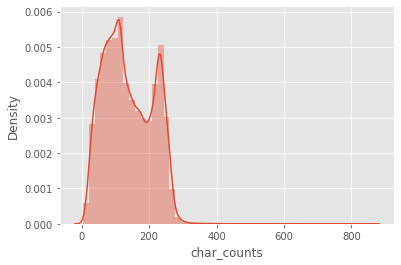

In [ ]:
import seaborn as sns
sns.distplot(df['char_counts'])

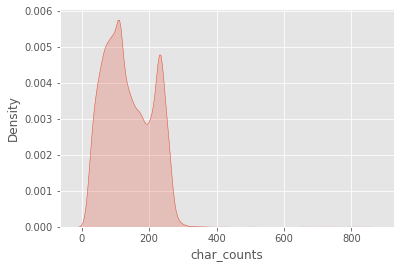

In [ ]:
sns.kdeplot(df['char_counts'], shade=True)

In [ ]:
# bigram = get_ngram(df1, 'Tweet', ngram_range=2)

In [ ]:
def get_clean(x):
  x = str(x).lower().replace('\\', '').replace('_', ' ').replace('.',' ')
  x = cont_exp(x)
  x = remove_emails(x)
  x = remove_urls(x)
  x = remove_html_tags(x)
  x = remove_rt(x)
  x = remove_accented_chars(x)
  x = remove_special_chars(x)
  x = remove_dups_char(x)
  #x = re.sub("(.)\\1{2,}", "\\1", x)
  return x

In [ ]:
df1['Tweet'] = df1['Tweet'].apply(lambda x: get_clean(x))

In [ ]:
df1.head()['Tweet']

0                                        emotional day
1    rachel nichols and then that kid ruled the bas...
2    did you check thatguytoli rossman theresa brut...
3    i want to be an accomplice if im ever anything...
4                 money money make ops as blac kshipra
Name: Tweet, dtype: object

In [ ]:
get_ngram(df1, 'Tweet', ngram_range=2)

[('zzs perbis', 157843),
 ('zzliaa by', 157842),
 ('zzestebanrzz yo', 157841),
 ('zz 10k', 157840),
 ('zyxcondones kev', 157839),
 ('zyrtec to', 157838),
 ('zynfairyy yess', 157837),
 ('zynb0x pineapple', 157836),
 ('zyl9hh hulu', 157835),
 ('zwelinzima1 when', 157834),
 ('zweliking tina', 157833),
 ('zvysofia hater', 157832),
 ('zuzanasuzy1 forzalillois59', 157831),
 ('zuul httpst', 157830),
 ('zuriag yes', 157829),
 ('zureiil for', 157828),
 ('zuo the', 157827),
 ('zumbolar looked', 157826),
 ('zumba not', 157825),
 ('zuma just', 157824),
 ('zuma is', 157823),
 ('zukunft die', 157822),
 ('zuizllz steveg60117', 157821),
 ('zuckerberg and', 157820),
 ('zucchini recipe', 157819),
 ('zucchini is', 157818),
 ('zucchini httpst', 157817),
 ('zubymusic brahma', 157816),
 ('zu good', 157815),
 ('zthemanloi lawsonfn1', 157814),
 ('zt won', 157813),
 ('zs boy', 157812),
 ('zramkumar26 hi', 157811),
 ('zpbull zzs', 157810),
 ('zoya idle', 157809),
 ('zoros rightnut', 157808),
 ('zooted tees', 15

In [ ]:
twitter_dataset = pd.concat([df, df1])

In [ ]:
twitter_dataset

,Date,User,Tweet,Retweets,Followers,Hashtags,Location,Place,Likes,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,2023-02-08 05:06:05+00:00,KenRaty,wallybigwall joneshospodtx cfidd i love it but...,0,106,None,None,None,0,168,33,5.090909,16,0,5,3,1
1,2023-02-08 05:06:01+00:00,DileepKumarPak,search and rescue operations resumed at the si...,0,280,"[Gilgit, Rawalpindi, Pakistan, accident, CarBu...",None,None,0,138,18,7.666667,4,5,0,3,0
2,2023-02-08 05:06:00+00:00,DSWDfo7,our community volunteers in brgy canagahan of ...,0,1904,None,None,None,0,188,28,6.714286,6,0,1,7,1
3,2023-02-08 05:05:48+00:00,migzu17,yugivee by accident i was originally going to ...,0,416,None,None,None,0,160,38,4.210526,17,0,1,5,4
4,2023-02-08 05:05:47+00:00,darrellriffic,hishyar09205113 mdoe99500351 bozturkserkan dor...,0,54,None,None,None,0,301,57,5.280702,33,0,4,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2023-02-08 05:41:00+00:00,Anviksiki,science in public health today is what these s...,0,4375,None,None,None,2,143,28,5.107143,13,0,0,2,0
19996,2023-02-08 05:41:00+00:00,GoodPostReilly,bmrow you ever play mario and luigi superstar ...,0,3936,None,None,None,0,43,9,4.777778,3,0,1,0,0
19997,2023-02-08 05:41:00+00:00,PartyvilleMayor,added a new video roll it up casino sertified ...,0,1204,[video],None,None,0,98,14,7.000000,1,1,0,3,0
19998,2023-02-08 05:41:00+00:00,Murp1953Tim,mmpadellan yep credit where its due,0,7690,None,None,None,0,34,6,5.666667,1,0,1,2,0


In [ ]:
twitter_dataset.to_csv('twitter_dataset.csv', index=False)